# The CBS algorithm for MAPF

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
from MAPF.metrics import flowtime, makespan
                
from MAPF import MultiAgentAStar,CBS
%load_ext autoreload
%autoreload 2

%matplotlib inline

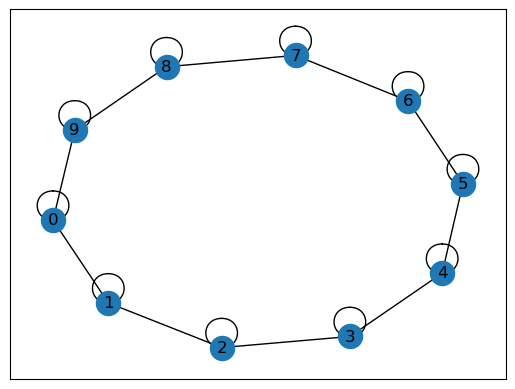

In [2]:
G = nx.circulant_graph(10,offsets = [0,1])
nx.draw_networkx(G)

In [120]:
# Basic components of the MAPF problem

G # The graph

start_nodes = tuple([0,1,2]) # Must be hashable.

goal_nodes = tuple([3,6,9]) 
# labeled_goals = True 

print('Multi-agent A*', MultiAgentAStar(G,start_nodes,goal_nodes,labeled_goals,check_edge_conflicts=True))

print('CBS',CBS(G,start_nodes,goal_nodes,check_edge_conflicts=True))

print('Backward Invariant CBS',BackwardInvariantCBS(G,start_nodes,goal_nodes,check_edge_conflicts=True))

Multi-agent A* (array([[0, 1, 2, 3, 3, 3, 3, 3],
       [1, 2, 3, 4, 5, 6, 6, 6],
       [2, 3, 4, 5, 6, 7, 8, 9]]), 15)
CBS ([[0, 9, 8, 7, 6, 5, 4, 3], [1, 0, 9, 8, 7, 6], [2, 1, 0, 9]], 15)
Backward Invariant CBS ([[0, 9, 8, 7, 6, 5, 4, 3], [1, 0, 9, 8, 7, 6], [2, 1, 0, 9]], 15)


In [201]:
from time import time

n_nodes = 400

ldim = int(np.ceil(np.sqrt(n_nodes)))
udim = int(np.floor(np.sqrt(n_nodes)))
G = nx.grid_graph([ldim,udim])
G = nx.convert_node_labels_to_integers(G)

for i in range(len(G)):
    G.add_edge(i,i)
    
n_nodes = G.number_of_nodes()

n_agents = 25

np.random.seed(232)

for _ in range(10):
    
    start_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) # Must be hashable.

    goal_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) 
    # print(start_nodes,goal_nodes)
    
    labeled_goals = True 
    
     
    
    print('CBS')
    t = time()
    result = CBS(G,start_nodes,goal_nodes,labeled_goals,max_iter=8000)
    if result:
        CBS_sol, CBS_ft = result
    else:
        print('CBS no solution')
        continue
    CBS_time = time()-t

    print('back inv CBS')
    t = time()
    result = BackwardInvariantCBS(G,start_nodes,goal_nodes,max_iter = 8000)
    if result:
        back_sol,back_ft = result
    else:
        print('back inv CBS no solution')
        continue
    back_time = time()-t
    # print('Multi-agent A*', result, 'time', MAAS_time)
   
    
    # if _:
    print('CBS Flowtime == backinv CBS Flowtime?',CBS_ft == back_ft)
    
    if CBS_ft!=back_ft:
        print(CBS_ft,CBS_sol,back_ft,back_sol)
        print(start_nodes,goal_nodes)

        # nx.draw_networkx(G)
        # plt.show()
        # break


CBS
Total iterations =  93 OPEN empty? False
back inv CBS
Total iterations =  8001 OPEN empty? False
back inv CBS no solution
CBS
Total iterations =  329 OPEN empty? False
back inv CBS
Total iterations =  202 OPEN empty? False
CBS Flowtime == backinv CBS Flowtime? False
278 [[252, 232, 212, 192, 172, 152, 132, 112, 92, 93], [312, 311, 310, 309, 308, 307, 306, 326, 346], [107, 87, 67, 47, 27, 26, 25, 24, 23, 22, 21, 20], [57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 68, 88], [274, 273, 272, 271, 291, 311, 331], [244, 243, 242, 241], [354, 334, 314, 294, 274, 254, 234, 214, 194], [377, 376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 345], [307, 287, 267, 247, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238], [373, 353, 333, 313, 293, 273, 253, 233, 213, 193, 173, 153, 133, 113, 112, 92, 72, 71, 70, 69, 68, 67], [303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314], [16, 15, 14, 13, 12, 11, 31], [124, 144, 145, 146, 147, 148, 149, 150, 151, 152], [115, 135, 155, 1

In [39]:
from queue import PriorityQueue
import networkx as nx
import numpy as np
from copy import deepcopy


from MAPF.metrics import flowtime, makespan
from MAPF import SpaceTimeAStar
from MAPF.conflict import find_conflict
from MAPF.HighLevelSearchTree import ConstraintTree

In [190]:

def BackwardInvariantCBS(G, start_nodes,goal_nodes, edge_weights = None, max_iter = 2000, metric = 'flowtime', check_edge_conflicts = False):


    if metric == 'flowtime':
        metric = flowtime
    elif metric == 'makespan':
        metric = makespan
    else:
        print('Metric {} is not supported. Please input "flowtime" or "makespan".'.format(metric))

    if edge_weights is None:
        edge_weights = {e:1 for e in G.edges} # Assume uniform weights if None is given.
        edge_weights.update({e[::-1]:1 for e in G.edges})

    nx.set_edge_attributes(G,edge_weights,'weight')

    hScore = dict(nx.shortest_path_length(G,weight = 'weight')) # The heuristic score used in SpaceTimeAStar

    # Initialization: 
    # Plan inidivual paths for agent agent without considering conflicts.
    # We simply call the standard networkx library.
    p = nx.shortest_path(G,weight = 'weight') # The [weight] argument here should be the key to weight values in the edge data dictionary.
    plan0 = [p[s][g] for s, g in zip(start_nodes, goal_nodes)]

    CT = ConstraintTree()
    ROOT = CT.add_node(None,plan0,metric(G,plan0,goal_nodes),[]) # Adding the root node. 

    OPEN = PriorityQueue()
    OPEN.put((CT.get_cost(ROOT),ROOT)) 

    count = 0
    while not OPEN.empty() and count<=max_iter:
        count+=1 
        # CBS does not have a way to determine infeasibility. 
        # To avoid infinite loops, we stop it when it exceeded an iteration threshold..


        cost, parent_node = OPEN.get()
        solution = CT.get_solution(parent_node)

        # Look for the first conflict.
        conflict = find_conflict(solution,check_edge_conflicts)

        # print(OPEN.queue, conflict,solution)
        if not conflict:
            # print('Solution found', solution, cost)
            # break
            
            print('Total iterations = ',count,'OPEN empty?',OPEN.empty()) 
            return solution, cost
        else:

            a1, a2, c, t = conflict # c could either be a node or an edge.
            # print('conflict',conflict)

            if type(c) is int:
                t0 = t-1
            elif type(c) is tuple:
                t0 = t

            for a in (a1,a2): # Create two children of the current CT node.
               
                # Construct the constraint set
                other_agent_pos = set()
                other_traversed_edges = set()
                for i in range(len(solution)):
                    if i!=a:
                        next_t = min(t0+1,len(solution[i])-1)
                        other_agent_pos.add(solution[i][next_t])
                        other_traversed_edges.add(tuple(solution[i][next_t-1:next_t+1]))

                # print('other agent pos',other_agent_pos)
                # Construct the constraint set for the agent.
                node_constraints = {s:set() for s in G}            
                for s in other_agent_pos:
                    node_constraints[s].add(1)

                edge_constraints = {e:set() for e in G.edges}
                edge_constraints.update({e[::-1]:set() for e in G.edges})

                for e in other_traversed_edges: 
                    if len(e)>1:# Ignore the traverses which stay at the same node.
                        edge_constraints[e].add(0)

                if type(c) is int:
                    node_constraints[c].add(1)
                elif type(c) is tuple:
                    edge_constraints[c].add(0)
                    edge_constraints[c[::-1]].add(0)


                # print('agent',a,'node constraints',node_constraints,'c',c)
                # print('solution[a]', solution[a],'t0',t0)
                # Call Space-time A* algorithm to partially replan the agent's path.
                curr_t = min(t0,len(solution[a])-1)
                result = SpaceTimeAStar(G, start=solution[a][curr_t], goal=goal_nodes[a]\
                                        ,node_constraints=node_constraints,edge_constraints=edge_constraints\
                                        , hScore = hScore)

                if result: # If there is a feasible single-agent path. 
                    # print('result',result,'start',solution[a][t-1],'goal',goal_nodes[a],'solution',solution)
                    path, gscore = result
                    new_solution = deepcopy(solution)
                    new_solution[a] = solution[a][:curr_t] + path
                    # if count>=0.98*max_iter:
                    # print('agent',a,'old_solution',solution,'new_solution',new_solution)
                    # print('old_solution[a]',solution[a],'new_solution[a]',new_solution[a],'path',path)
                    # print('old_solution[:t]',solution[a][:curr_t])
                    

                    # Create a new child in the Constraint Tree.
                    new_node_ID = CT.add_node(parent_node, new_solution,\
                                                 metric(G,new_solution,goal_nodes),[])

                    # Push the new child onto the OPEN queue.
                    OPEN.put((CT.get_cost(new_node_ID),new_node_ID))
                # else:
                #     print('No SAPF solution')

    print('Total iterations = ',count,'OPEN empty?',OPEN.empty()) 
    return None

            

In [88]:
path

[1, 1, 0, 9]

In [87]:
solution[0][:t]

[]